In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import math

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim,dropout=0.2):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])

        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.proj(x)  
        x = x.flatten(2)  
        x = x.transpose(1, 2) 
        x=self.dropout(x)
        return x
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).transpose(0, 1)

    def forward(self, x):
        return x + self.encoding[:x.size(0), :]
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers, num_classes,dropout=0.2):
        super(ViT, self).__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.position_encoding = PositionalEncoding(embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.classifier = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.position_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x=self.dropout(x)  
        x = self.classifier(x)
        return x

In [18]:
import torchvision.models as models
import timm
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
cnn_model = models.resnet18(pretrained=False)
in_features=cnn_model.fc.in_features
cnn_model.fc=nn.Linear(in_features,100)
transformer_model = ViT(img_size=[224,224],patch_size=[16,16],in_channels=3,embed_dim=256,num_heads=8,num_layers=12,num_classes=100)
cnn_params = count_parameters(cnn_model)
transformer_params = count_parameters(transformer_model)
print(f"ResNet-18参数量: {cnn_params}")
print(f"ViT 参数量: {transformer_params}")

ResNet-18参数量: 11227812
ViT 参数量: 16003428


In [19]:
import numpy as np 
def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.random.beta(alpha, alpha)
    lam = max(lam, 1 - lam)

    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
    # Adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    # Compute output
    target_a = target
    target_b = shuffled_target
    return data, target_a, target_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [20]:
import copy
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

train_dataset = torchvision.datasets. CIFAR100(root='./data', train=True, download=False, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=False, transform=test_transform)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_initial_state = copy.deepcopy(cnn_model.state_dict())
transformer_initial_state=copy.deepcopy(transformer_model.state_dict())
cnn_model.to(device)
transformer_model.to(device)

ViT(
  (patch_embedding): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (position_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=256, out_features=100, bias=True)
  (dropou

In [21]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR,StepLR
def train(model,train_dataset,val_dataset,batch_size=32,lr=0.0001,epoch=100,alpha=1,warmup_epochs=40, T_max=360,step_size=50, gamma=0.1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler_warmup = CosineAnnealingLR(optimizer, T_max=T_max)
    scheduler_decay = StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=8)
    val_dataloader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=8)
    losses=[]
    val_losses=[]
    train_acces=[]
    val_acces=[]
    best_acc=0
    best_epoch=0
    for i in range(epoch):
        model.train()
        running_loss = 0
        running_correct = 0
        total_train = 0
        if i < warmup_epochs:
            warmup_lr = lr * (i + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = warmup_lr
        for batch in train_dataloader:
            img,label=batch
            optimizer.zero_grad()
            img=img.to(device)
            label=label.to(device)
            if np.random.rand() > 0.5:
                data, target_a, target_b, lam = cutmix(img, label, alpha=alpha)
                output = model(data)
                train_loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
            else:
                output = model(img)
                train_loss = criterion(output, label)
            train_loss.backward()
            optimizer.step()
            running_loss += train_loss.item() * img.size(0)
            _, predicted = torch.max(output, 1)
            running_correct += (predicted == label).sum().item()
            total_train += label.size(0)
            train_loss = running_loss / total_train
        train_acc = running_correct / total_train
        losses.append(train_loss)
        train_acces.append(train_acc)
        model.eval()
        val_loss = 0
        correct = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_dataloader:
                img, label = batch
                img = img.to(device)
                label = label.to(device)
                output = model(img)
                loss = criterion(output, label)
                val_loss += loss.item() * img.size(0)
                _, predicted = torch.max(output, 1)
                correct += (predicted == label).sum().item()
                total_val += label.size(0)
        val_epoch_loss = val_loss / total_val
        val_losses.append(val_epoch_loss)
        val_epoch_acc = correct / total_val
        val_acces.append(val_epoch_acc)
        print(f'Epoch [{i+1}/{epoch}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_epoch = i
            best_model_wts = copy.deepcopy(model.state_dict())
        if i >= warmup_epochs:
            scheduler_warmup.step()

        scheduler_decay.step()
    print(f'Best epoch: {best_epoch+1} with accuracy: {best_acc:.4f}')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Loss over Epochs')
    plt.plot(losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
            
    plt.subplot(1, 2, 2)
    plt.title('Accuracy over Epochs')
    plt.plot(train_acces, label='Train Accuracy')
    plt.plot(val_acces, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    model.load_state_dict(best_model_wts)

Epoch [1/50], Train Loss: 1.7858, Train Acc: 0.7032, Val Loss: 1.3113, Val Acc: 0.7348
Epoch [2/50], Train Loss: 1.6603, Train Acc: 0.7260, Val Loss: 1.3097, Val Acc: 0.7347
Epoch [3/50], Train Loss: 1.6873, Train Acc: 0.7208, Val Loss: 1.2786, Val Acc: 0.7360
Epoch [4/50], Train Loss: 1.6910, Train Acc: 0.7224, Val Loss: 1.2746, Val Acc: 0.7364
Epoch [5/50], Train Loss: 1.6115, Train Acc: 0.7262, Val Loss: 1.2737, Val Acc: 0.7357
Epoch [6/50], Train Loss: 1.6363, Train Acc: 0.7241, Val Loss: 1.2444, Val Acc: 0.7363
Epoch [7/50], Train Loss: 1.6776, Train Acc: 0.7216, Val Loss: 1.2363, Val Acc: 0.7373
Epoch [8/50], Train Loss: 1.6343, Train Acc: 0.7189, Val Loss: 1.2053, Val Acc: 0.7384
Epoch [9/50], Train Loss: 1.6483, Train Acc: 0.7196, Val Loss: 1.2077, Val Acc: 0.7367
Epoch [10/50], Train Loss: 1.6339, Train Acc: 0.7194, Val Loss: 1.1830, Val Acc: 0.7382
Epoch [11/50], Train Loss: 1.6046, Train Acc: 0.7226, Val Loss: 1.1713, Val Acc: 0.7391
Epoch [12/50], Train Loss: 1.6105, Train 

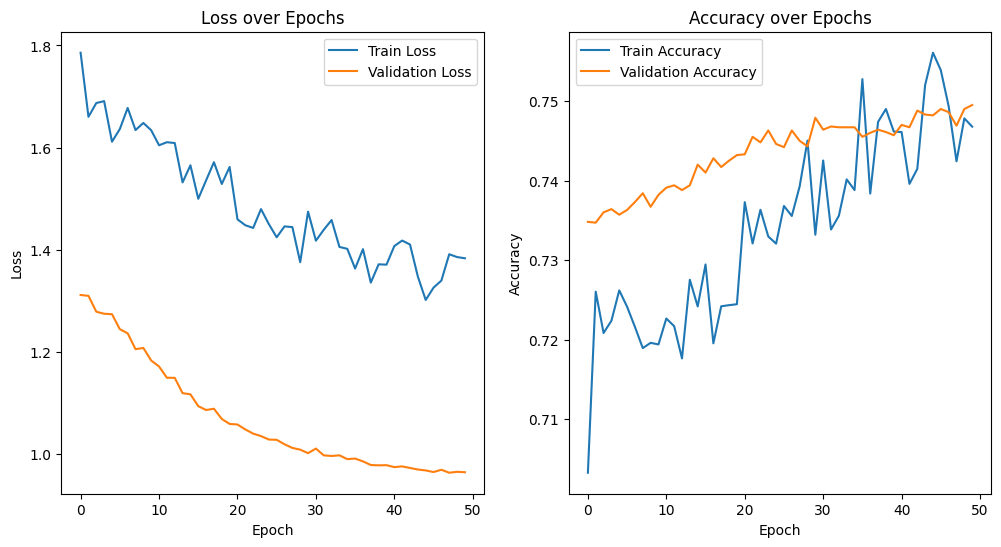

In [25]:
cnn_model.load_state_dict(torch.load('/atlas/final/cnn_model_weights_pth'))
train(cnn_model,train_dataset=train_dataset,val_dataset=test_dataset,batch_size=128,lr=0.00001,epoch=50)

In [26]:
torch.save(cnn_model.state_dict(),'cnn_model_weights_pth')